# **Clone Clustering & Turnover Inference**

In [63]:
projectdir = "C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, Pipe, ProgressMeter, StatsPlots, Distributed, Roots, LinearAlgebra, BSON, Random
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try SeqDataFormatting
catch e
    include(projectdir*"experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include(projectdir*"scripts/distribution_functions.jl")
include(projectdir*"simulated_tumors/path_format.jl")
include(projectdir*"Turnover/src/utility.jl")
# include(projectdir*"sampling_analysis/plot_funcs.jl")
include("experimental_data/lichee_cloneclustering.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


In [4]:
rmprocs(workers())
addprocs(4)
@everywhere using Pkg
@everywhere Pkg.activate(pwd())
@everywhere import TumorGrowth

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\Distributed\src\cluster.jl:1038
  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


      From worker 3:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
      From worker 4:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
      From worker 5:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
      From worker 2:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


# Data

In [34]:
tumorinfo_2d = filter( r-> r.d == 0.8, dir_info_mutations(projectdir*"/simulated_tumors/2d_poisson/bulk") )
# tumorinfo_2d_series = filter( r-> r.d != 0.98 && r.N == 10000, dir_info_mutations(projectdir*"/simulated_tumors/2d/bulk") )
tumorinfo_3d = filter( r-> r.d in 0.8:0.2:0.8 && r.mu == 0.3, dir_info_mutations(projectdir*"/simulated_tumors/3d_poisson/bulk") )
# tumorinfo_nonspatial = filter( r-> r.d in 0.2:0.2:0.8, dir_info_mutations(projectdir*"/simulated_tumors/nonspatial"))
# tumorinfo_selection = filter( r-> true, load_selection_tumors(projectdir*"/simulated_tumors/selection/nonspatial"))
tumorinfo_selection = filter( r-> true, load_selection_tumors(projectdir*"/simulated_tumors/selection/3d_poisson/bulk"))
;

In [35]:
tumorinfo = tumorinfo_3d

tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.tumorpath)
tumorinfo.mutations = @showprogress pmap(TumorGrowth.data_import, tumorinfo.mutationspath)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


# Example

In [265]:
Random.seed!(2022)
tumor = deepcopy( tumorinfo_nonspatial.tumor[1] )

tumor = tumor[sample(1:nrow(tumor), 285, replace=false), :]
tumor.index .= 1:nrow(tumor)

nmuts = length(union(tumor.mutations...))
TumorGrowth.reduced_μ!(tumor, 50 / nmuts)
tumor.frequencies = map(ones, length.(tumor.mutations))
tumor.sample_r = ones(nrow(tumor));

In [304]:
params = read_params(tumorinfo_nonspatial.tumorpath[1])
name = write_path(;params...)[1]

"tumor_N40000_b1.0_d0.98_μ0.015_ρInf_0d_id1009.csv"

> coinc

In [286]:
# clones, sample_clone_mix = coincidence_clustering(tumor)
clonetumor_coinc = coincidence_clustering_clonetumor(tumor)
first(clonetumor_coinc,4)

,new_index,mutations
,Int64,Array…
1,1,[10]
2,2,[10]
3,3,[10]
4,4,[10]


In [290]:
clonetumor_coinc.mutations |> unique .|> length |> countmap

Dict{Int64, Int64} with 4 entries:
  4 => 4
  2 => 30
  3 => 9
  1 => 2

In [309]:
CSV.write("simulated_tumors/lichee/clonetumor_coinc_$(name)", delim="\t",  clonetumor_coinc)

"simulated_tumors/lichee/clonetumor_coinc_tumor_N40000_b1.0_d0.98_μ0.015_ρInf_0d_id1009.csv"

> LICHeE

In [312]:
mut2ind, snv_lichee = get_lichee_format(tumor);

In [313]:
CSV.write("simulated_tumors/lichee/tumorsim_lichee.csv", delim="\t",  snv_lichee);

In [314]:
lichee_dir = joinpath("C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/",
    "Workspace/lichee/LICHeE/release")
input = joinpath(projectdir, "simulated_tumors/lichee/tumorsim_lichee.csv")
lichee_cmd = `bash ./lichee -build -i $input -maxVAFAbsent 0.005 -minVAFPresent 0.01 -n 0 -maxClusterDist 0 -minClusterSize 1 -minProfileSupport 1 minRobustNodeSupport 1 -s 1 -sampleProfile`
run(Cmd(lichee_cmd, dir=lichee_dir));

There are 46 SNVs in the input file. 
After pre-processing, the input consists of 46 somatic SNVs. 

Found 1 valid tree(s)


In [315]:
data, offspring2parent = load_lichee_output("simulated_tumors/lichee/tumorsim_lichee.csv.trees.txt", mut2ind = mut2ind);

In [316]:
clonetumor_lichee = lichee_clonetumor(tumor, data)
first(clonetumor_lichee,4)

,index,sample_index,position,mutations,sample_frequency,sample_r
,Int64,Int64,Array…,Array…,Float64,Float64
1,1,277,[],"[13289, 10]",0.5,1.0
2,2,31,[],"[13024, 10]",0.5,1.0
3,3,138,[],"[10749, 10]",0.5,1.0
4,4,198,[],"[6848, 245, 10]",0.5,1.0


In [317]:
clonetumor_lichee.mutations |> unique .|> length |> countmap

Dict{Int64, Int64} with 4 entries:
  4 => 4
  2 => 30
  3 => 9
  1 => 2

In [318]:
CSV.write("simulated_tumors/lichee/clonetumor_lichee_$(name)", delim="\t",  clonetumor_lichee)

"simulated_tumors/lichee/clonetumor_lichee_tumor_N40000_b1.0_d0.98_μ0.015_ρInf_0d_id1009.csv"

#  Methods

> clustering

In [7]:
clustering_method = samplingtumor -> begin
    
    tempfile = joinpath(projectdir, "simulated_tumors/lichee/tumorsim_lichee_temp.csv")
    lichee_dir = joinpath(projectdir, "../../lichee/LICHeE/release")
    
    clonetumor_coinc = coincidence_clustering_clonetumor(deepcopy(samplingtumor))
    
#     mut2ind, snv_lichee = get_lichee_format(samplingtumor)
#     select!(snv_lichee, Not(:profile))
#     CSV.write(tempfile, delim="\t",  snv_lichee)
    clonetumor_lichee = DataFrame(:index => [0], :mutations=>[[]])
    
#     try
#         lichee_cmd = `bash ./lichee -build -i $tempfile -maxVAFAbsent 0.005 -minVAFPresent 0.01 -n 0 -maxClusterDist 0 -minClusterSize 1 -minProfileSupport 1 minRobustNodeSupport 1 -s 1`# -sampleProfile`
#         run(Cmd(lichee_cmd, dir=lichee_dir))
#         data, offspring2parent = load_lichee_output(tempfile*".trees.txt", mut2ind = mut2ind)
#         clonetumor_lichee = lichee_clonetumor(samplingtumor, data)
#     catch e
#     end
    
    # sort!(clonetumor_lichee.mutations)
    (clonetumor_coinc = clonetumor_coinc, clonetumor_lichee = select(clonetumor_lichee, :index, :mutations), )
end

#635 (generic function with 1 method)

> sample plane (2d)

In [38]:
samplecutoff= 1/5
samplingparams = (n = 285, cells_per_sample = 10)

sampling_method = tumor -> begin
    _, wes_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = 30, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 20)

    mutations_wes = TumorGrowth.sampletumor_mfreqs(wes_sample)
    filter!(m->m.frequency>1/100, mutations_wes)
    # mutations_wes = mutations_wes[sample(1:nrow(mutations_wes), 35),:]

    _, sanger_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 5)

    for row in eachrow(sanger_sample)
        mask = [ m in mutations_wes.mutation && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
        row.mutations = row.mutations[mask]
        row.frequencies = row.frequencies[mask]
    end
    sanger_sample
end

#281 (generic function with 1 method)

> sample cross-section (3d)

In [30]:
samplecutoff= 1/3
samplingparams = (n = 317, cells_per_sample = 5)

sampling_method = tumor_3d -> begin
    
    x, cm = mean(tumor_3d.position)
    tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=2.5, reduce_dim=true)
    
    _, wes_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = 30, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 20)

    mutations_wes = TumorGrowth.sampletumor_mfreqs(wes_sample)
    # filter!(m->m.frequency>1/100, mutations_wes)
    # mutations_wes = mutations_wes[sample(1:nrow(mutations_wes), 35),:]

    _, sanger_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 5)

    for row in eachrow(sanger_sample)
        mask = [ m in mutations_wes.mutation && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
        row.mutations = row.mutations[mask]
        row.frequencies = row.frequencies[mask]
    end
    sanger_sample
end

#661 (generic function with 1 method)

> sample Li slices (3d)

In [44]:
@everywhere include("experimental_data/Li/Li_like_sampling.jl")

In [87]:
tumor_name = "T1"
sanger = TumorGrowth.data_import("experimental_data/Li/Li_data_$(tumor_name)_sanger.tsv", delim="\t")
wes = TumorGrowth.data_import("experimental_data/Li/Li_data_$(tumor_name)_wes.tsv", delim="\t");

In [88]:
res = tumor_name == "T1" ? 1/100 : 1/100
samplecutoff= 1/5
samplingparams = (cells_per_sample = 5, stochastic=false, readdepth=5,);

sampling_method = tumor_3d -> begin

    wes_slices = Li_like_sampling( tumor_3d; li_tumor=wes, samplingparams=(cells_per_sample = 20, stochastic=true, readdepth=10,))

    slices = Li_like_sampling( tumor_3d; li_tumor=sanger, samplingparams=samplingparams)

    samples_freqs = TumorGrowth.sampletumor_mfreqs(wes_slices)
    filter!(r->r.frequency > res, samples_freqs)
    for row in eachrow(slices)
        mask = [ m in samples_freqs.mutation && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
        
        row.mutations = row.mutations[mask]
        row.frequencies = ones(count(mask))
        
        # if true in mask
        #     delete_ind= rand(1:sum(mask))
        #     deleteat!(row.mutations, delete_ind)
        #     deleteat!(row.frequencies, delete_ind)
        # end
        
        # noise = sample( setdiff(samples_freqs.mutation, row.mutations), 1, replace=false)
        # append!(row.mutations, noise)
        # append!(row.frequencies, ones(length(noise)))
    end

    slices
end

#1335 (generic function with 1 method)

> single cells

In [232]:
sampling_method = tumor -> begin
    
    # mutations = TumorGrowth.mutation_freqs(tumor[sample(1:nrow(tumor), 100, replace=false),:] )
    # filter!(r->r.reads > 4, mutations)
    
    samplingtumor = deepcopy( tumor[sample(1:nrow(tumor), 5000, replace=false), :] )
    # samplingtumor = deepcopy(tumor)
    
    mutations = TumorGrowth.mutation_freqs(samplingtumor)
    filter!(r->r.frequency > 1/1000, mutations)
    
    filter!.(m -> m in mutations.mutation, samplingtumor.mutations)
    # samplingtumor.index .= 1:nrow(samplingtumor)
    # samplingtumor.frequencies = map(ones, length.(samplingtumor.mutations))
    # samplingtumor.sample_r = ones(nrow(samplingtumor));
    samplingtumor
end

#472 (generic function with 1 method)

In [10]:
tumorinfo_nonspatial.tumor[1] |> sampling_method  |> clustering_method

There are 273 SNVs in the input file. 
After pre-processing, the input consists of 273 somatic SNVs. 

Found 1 valid tree(s)


(clonetumor_coinc = 2000×2 DataFrame
  Row │ new_index  mutations                         
      │ Int64      Array…                            
──────┼──────────────────────────────────────────────
    1 │         1  [8, 20, 24, 31, 47, 195, 281]
    2 │         2  [8, 35, 51, 177]
    3 │         3  [8, 20, 24, 31, 47, 218]
    4 │         4  [1, 65, 66, 71, 83, 1236, 1375, …
    5 │         5  Int64[]
    6 │         6  [3, 69, 366, 391]
    7 │         7  [8, 9, 30, 37]
    8 │         8  [8, 20, 24, 31, 47, 195, 281, 36…
    9 │         9  Int64[]
   10 │        10  [8]
   11 │        11  [8, 9, 30]
  ⋮   │     ⋮                      ⋮
 1991 │      1991  [8, 76]
 1992 │      1992  [393]
 1993 │      1993  [8, 20, 24, 31, 47]
 1994 │      1994  [14]
 1995 │      1995  [8, 20]
 1996 │      1996  [257, 262]
 1997 │      1997  [8, 76, 206, 545, 610]
 1998 │      1998  [560, 1909, 8090]
 1999 │      1999  [1871, 3791]
 2000 │      2000  Int64[]
                                    1979 

In [23]:
tumorinfo_2d.tumor[1] |> sampling_method  |> clustering_method

(clonetumor_coinc = 1393×2 DataFrame
  Row │ new_index  mutations             
      │ Int64      Array…                
──────┼──────────────────────────────────
    1 │         1  [8, 31]
    2 │         2  [8, 58]
    3 │         3  [8, 14, 61]
    4 │         4  [8, 14, 82]
    5 │         5  [8, 14, 102]
    6 │         6  [8, 31]
    7 │         7  [8, 14, 61]
    8 │         8  [8, 14, 84]
    9 │         9  [8, 14, 58, 91]
   10 │        10  [8, 31]
   11 │        11  [8, 51]
  ⋮   │     ⋮                ⋮
 1384 │      1384  [8, 34, 114]
 1385 │      1385  [8, 22, 34, 349]
 1386 │      1386  [8, 22]
 1387 │      1387  [8, 34]
 1388 │      1388  [8, 22, 34, 74]
 1389 │      1389  [8, 78]
 1390 │      1390  [8, 64]
 1391 │      1391  [8, 22, 34, 74]
 1392 │      1392  [8, 22]
 1393 │      1393  [8, 34, 114]
                        1372 rows omitted, clonetumor_lichee = 1×2 DataFrame
 Row │ index  mutations 
     │ Int64  Array…    
─────┼──────────────────
   1 │     0  Any[])

In [20]:
let t = tumorinfo_2d.tumor[4]
    samplingtumor = t |> sampling_method
    clonetumor_coinc, clonetumor_lichee = t |> sampling_method |> clustering_method
    mutations = union(samplingtumor.mutations...)
    clones_ = filter( clone_ -> all( m in mutations for m in clone_)  , unique(t.mutations))
    println(sort(sort.(clones_),by=length)[1:10])
    println("")
    println(sort(sort.(unique(clonetumor_coinc.mutations)),by=length)[1:10])
    println("")
    println(sort(sort.(unique(clonetumor_lichee.mutations)),by=length)[1:10])
end
    

There are 174 SNVs in the input file. 
After pre-processing, the input consists of 174 somatic SNVs. 

Found 0 valid tree(s)
Adjusting the network...
Removed cluster 0 of group 000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000010000000000000001100000000000000110100000000000001010000000000000000111000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000000 of size 1 with members: 
chr1	294	294	000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000010000000000000001100000000000000110100000000000001010000000000000000111000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000000	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0

[[425], [91, 611], [425, 1376], [8, 31], [34, 71, 536], [34, 71, 824], [10, 28, 294], [470, 499, 633], [70, 960, 1320, 3006], [34, 71, 799, 2730]]

[[91], [70], [425], [8], [91, 496], [411, 495], [8, 31], [91, 177], [470, 499], [34, 71]]

[[175], [91], [70], [31], [1376], [116], [183, 194], [411, 495], [470, 499], [34, 71]]


In [8]:
tumorinfo_3d.tumor[1] |> sampling_method  |> clustering_method

There are 32 SNVs in the input file. 
After pre-processing, the input consists of 32 somatic SNVs. 

Found 1 valid tree(s)


(clonetumor_coinc = 314×2 DataFrame
 Row │ new_index  mutations              
     │ Int64      Array…                 
─────┼───────────────────────────────────
   1 │         1  [1, 3, 44, 1041]
   2 │         2  [1, 3, 44, 1041]
   3 │         3  [1, 3, 222, 3786]
   4 │         4  [1, 3, 44, 1041]
   5 │         5  [1, 3, 222, 3786]
   6 │         6  Int64[]
   7 │         7  [1, 3, 44, 1041]
   8 │         8  [1, 3, 44, 1041]
   9 │         9  [1, 3, 36, 514]
  10 │        10  [1, 3, 44]
  11 │        11  [1, 3, 222, 3786]
  ⋮  │     ⋮                ⋮
 305 │       305  [1, 3, 84]
 306 │       306  [1, 3, 142, 404]
 307 │       307  [1, 3]
 308 │       308  [1, 3]
 309 │       309  [1, 3, 142, 404, 1787]
 310 │       310  [1, 3, 142, 404, 1787]
 311 │       311  [1, 3, 142, 404, 1787]
 312 │       312  [1, 3, 142, 404, 1787]
 313 │       313  [1, 3, 84]
 314 │       314  [1, 3, 142, 404, 1787]
                         293 rows omitted, clonetumor_lichee = 774×2 DataFrame
 Row │ in

## *plotting*

In [16]:
function plot_func(args...; layout=(1,4), kwargs...)
    p = plot(layout=layout, size=(225*layout[2],200*layout[1]), yguidefontrotation=-90, xtickfontsize=12,
        grid=false, ytickfontsize=12, margin=2Plots.mm, legend=:none, xguidefontsize=18, titlefontsize=18)
    plot_func!(p, args... )
end

plot_func (generic function with 1 method)

In [17]:
function plot_func!(p, N, d, mu, ds,Wa,Wo,dfits,mufits; plots = [:Wa, :Wo, :d, :mu],
        distribution! = violin!, dots! = dotplot!, scale = 5)
    
    n = 1
    if :Wa in plots
        distribution!(p[n], scale*ds, Wa, alpha=0.4,
            ylims=(1e-2,1), yscale=:log10, xlim=(scale*d-1,scale*d+1), 
            xticks=(scale*[d],[L"W_a"]), xtickfontsize=18,
            # xticks=(scale*(0.8:0.1:1.0), 0.8:0.1:1.0), title=L"W_a", xlab=L"d", xguidefontsize=15,
            )
        hline!(p[n],[Turnover.W_orphaned(d; N=N * (1-d))], c=:red)
        # plot!(p[n],scale .* (0.6:0.00001:1), q->Turnover.W_orphaned(q /scale; N=N * (1 - q/scale)),lab="", c=:red)
        dots!(p[n], scale*ds, Wa,c=:blue)
        n += 1
    end
    if :Wo in plots
        distribution!(p[n], scale*ds, Wo, alpha=0.4,
            ylims=(1e-2,1), yscale=:log10, xlim=(scale*d-1,scale*d+1), 
            xticks=(scale*[d],[L"W_o"]), xtickfontsize=18,
            # xticks=(scale*(0.8:0.1:1.0), 0.8:0.1:1.0), title=L"W_o", xlab=L"d", xguidefontsize=15,
            )
        hline!(p[n], [Turnover.W_estranged(d; b=1, μ = mu, T=log(N * (1-d) )/(1-d))], c=:red)
        # plot!(p[n], scale .* (0.6:0.00001:0.99), q->Turnover.W_estranged(q /scale; b=1, μ = mu, T=log(N * (1 - q/scale) )/(1-q/scale)), lab="", c=:red)
        dots!(p[n], scale*ds, Wo,c=:blue)
        n += 1
    end
    if :d in plots
        distribution!(p[n], scale*ds, 1 .- dfits, alpha=0.4,
            ylims=(1e-2,1), yscale=:log10,  
            xlim=(scale*d-1,scale*d+1), xticks=(scale*[d],[L"1-d"]), xtickfontsize=18,
            )
        hline!(p[n], [1-d], c=:red)
        # plot!(p[n], 0:0.01:scale, q-> 1 - q/scale, c=:red)
        dots!(p[n], scale*[ds], [1 .- dfits],c=:blue)
        n += 1
    end
    if :mu in plots
        distribution!(p[n], scale*ds, mufits, alpha=0.4,
            ylims=(1e-3,1e-0), yscale=:log10,
            xlim=(scale*d-1,scale*d+1), xticks=(scale*[d],[L"\mu"]), xtickfontsize=18,
            )
        hline!(p[n], [mu], c=:red)
        dots!(p[n], scale*ds, mufits,c=:blue)
    end
    p
end

plot_func! (generic function with 1 method)

# *reduce μ*

In [41]:
mus = [0.2, 0.1, 0.05]
mu_base = 0.3
Random.seed!(2000)
let tumorinfo = filter!(r->r.mu==mu_base,tumorinfo_3d)
    init = copy(tumorinfo)
    for mu in mus
        new_tumors = deepcopy(select(init, Not(:tumor)))
        new_tumors.mu .= mu
        new_tumors[!,:tumor] .= @showprogress pmap( init.tumor ) do t
            TumorGrowth.reduced_mu(t, mu/mu_base)
        end
        println(nrow(tumorinfo), nrow(new_tumors))
        append!(tumorinfo, new_tumors)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


4040


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


8040


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


12040


# Run clustering

In [89]:
Random.seed!(2000)
let tumorinfo = tumorinfo_3d
    tumorinfo.samplingtumor = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.clonetumor_coinc = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.clonetumor_lichee = Vector{DataFrame}(undef, nrow(tumorinfo))
    
    @showprogress for (i,r) in enumerate(eachrow(tumorinfo))

        samplingtumor =  r.tumor |> sampling_method 
        clonetumor_coinc, clonetumor_lichee = samplingtumor |> clustering_method
        
        sequencing = TumorGrowth.mutation_freqs(samplingtumor)
        sequencing, samplingtumor, clonetumor_coinc, clonetumor_lichee

        r.mutations.frequency = zeros(nrow(r.mutations))
        r.mutations.frequency[sequencing.mutation]  =  sequencing.reads
        
        r.samplingtumor = samplingtumor
        r.clonetumor_coinc = clonetumor_coinc
        r.clonetumor_lichee = clonetumor_lichee
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


# Inference

In [163]:
for row in eachrow( tumorinfo_3d )
    muts = row.tumor.mutations |> unique
    allowed = union(row.samplingtumor.mutations...)
    filter!.(m-> m in allowed, muts)
    muts |> unique! |> sort!
    println( length( muts ), " ",
        length( unique(row.clonetumor_coinc.mutations) ), " ",
        length( unique(row.clonetumor_lichee.mutations) ) )
end

78 71 73
98 90 72
92 80 84
91 84 1
90 80 83
118 107 112
90 84 84
99 85 89
89 78 80


In [13]:
for row in eachrow( tumorinfo_3d )
    muts = row.tumor.mutations |> unique
    allowed = union(row.samplingtumor.mutations...)
    filter!.(m-> m in allowed, muts)
    muts |> unique! |> sort!
    println( length( muts ), " ",
        length( unique(row.clonetumor_coinc.mutations) ), " ",
        length( unique(row.clonetumor_lichee.mutations) ) )
end

30 28 28
27 22 22
31 28 28
22 19 19
30 27 27
27 25 25
31 30 30
30 29 29
28 23 24
40 40 40
25 23 23
30 30 30
30 28 28
34 25 25
31 26 27
16 15 15
42 35 35
16 16 16
23 20 21
31 30 30
31 28 28
40 34 35
22 19 19
29 23 23
27 25 25
31 28 29
20 18 18
20 20 20
28 27 27
25 23 24
19 21 21
29 28 28
32 29 29
25 25 25
22 19 20
37 35 35
35 27 27
30 28 28
21 21 21
25 23 23


In [156]:
for row in eachrow( tumorinfo_3d )
    muts = row.tumor.mutations |> unique
    allowed = union(row.samplingtumor.mutations...)
    println(length(allowed))
end

158
153
137
123
146
130
133
122
146
114
123
119
148
161
110
129
134
131
144
133
148
137
149
153
121
159
131
155
106
118
144
135
143
130
141
146
137
140
127
154
104
98
82
78
98
88
85
76
77
81
84
86
90
104
84
82
96
82
93
96
96
97
88
106
90
91
91
102
81
84
98
98
102
92
105
104
92
89
88
105
57
40
47
49
44
53
46
38
58
31
47
41
43
57
42
36
34
45
51
46
48
42
50
48
47
55
51
47
38
33
51
41
37
54
45
44
47
49
46
49
28
25
15
26
14
17
24
23
26
17
21
26
24
24
26
19
19
18
22
23
29
16
31
21
24
28
24
21
21
17
24
26
19
16
27
25
18
18
22
36


In [18]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4103.479382591604

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


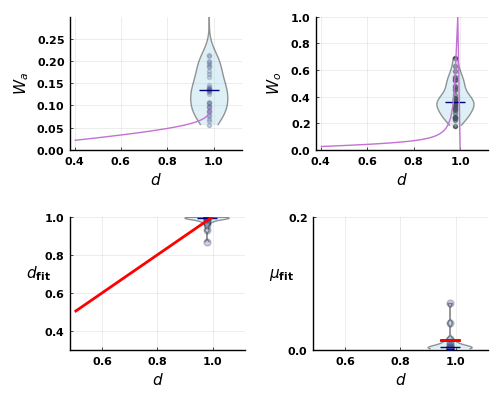

In [169]:
let tumorinfo = tumorinfo_3d

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N / f_min, mus=tumorinfo.μ[mask], size=(500,200), scalex=5,
        usecorrection=true, xlim=[0.4,1.1])

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=5, xlim=[0.5,1.1], ylim_d=(0.3,1), ylim_mu=(0,0.2))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

## 2d

In [184]:
N = 10000

10000

> samplingtumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.7127313139547854 | 0.98, mu 0.18416128545312918 | 0.015


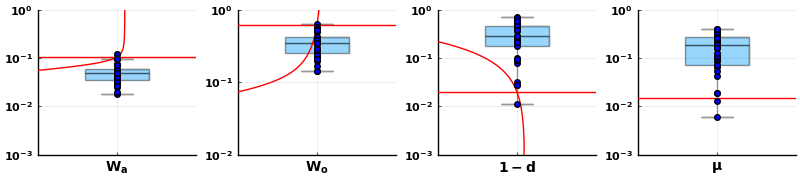

In [90]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_2d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds[mask],Wa[mask],Wo[mask],dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
    plot!(p[1], ylim=(1e-3,1))
end

> clonetumor_coinc

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9652969886282307 | 0.98, mu 0.01187615841840527 | 0.015


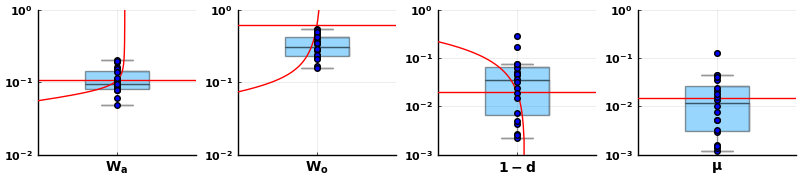

In [88]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_2d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds[mask],Wa[mask],Wo[mask],dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

> clonetumor_lichee

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9772960849667502 | 0.98, mu 0.006279833844373154 | 0.015


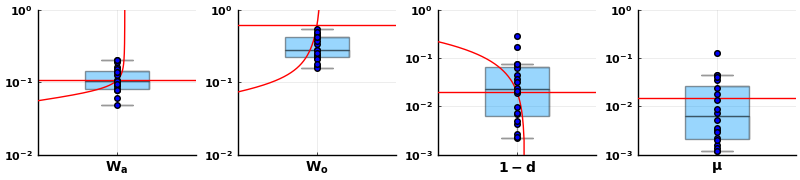

In [89]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_2d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds[mask],Wa[mask],Wo[mask],dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

## 3d

In [10]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4103.479382591604

> samplingtumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6309913196408365 | 0.98, mu 0.24926361995599428 | 0.015


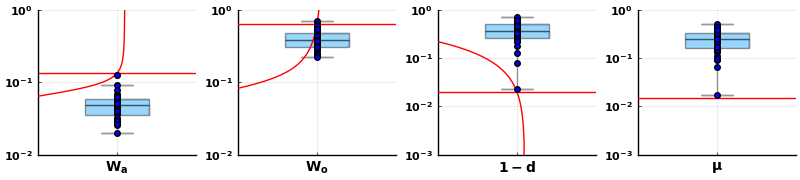

In [171]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6309913196408365 | 0.98, mu 0.24926361995599428 | 0.015


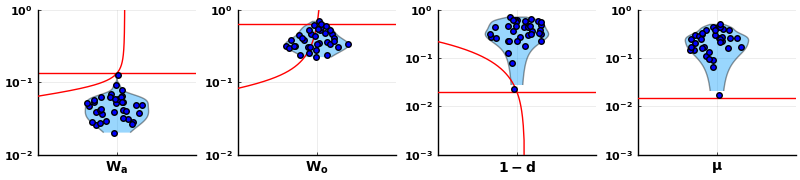

In [180]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

> clonetumor_coinc

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


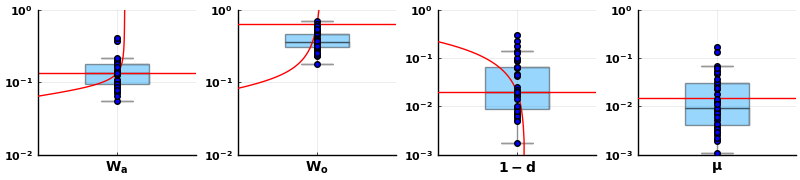

In [172]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


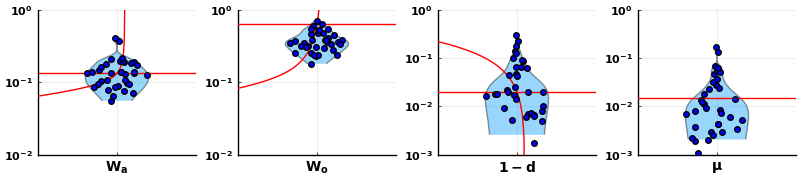

In [179]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


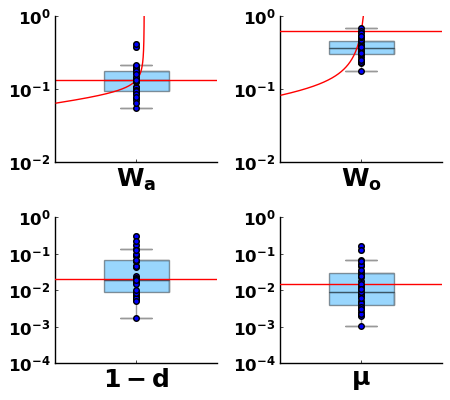

In [42]:
let
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[3], ylim=(1e-4,1))
    plot!(p[4], ylim=(1e-4,1))
end

In [43]:
name = "turnover_d0.98_mu0.015_coinc"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

> clonetumor_lichee

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


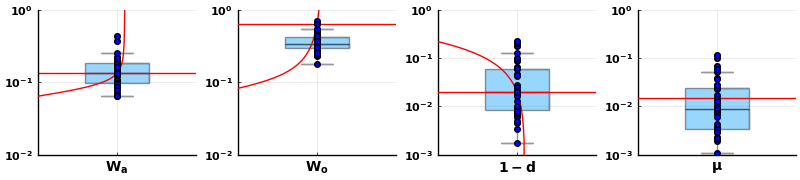

In [173]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


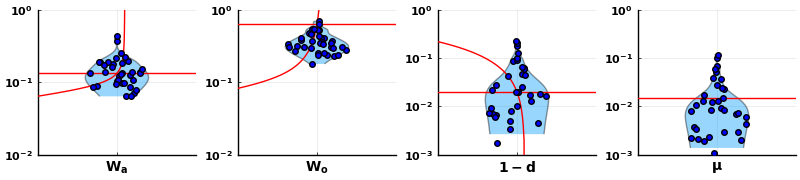

In [178]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


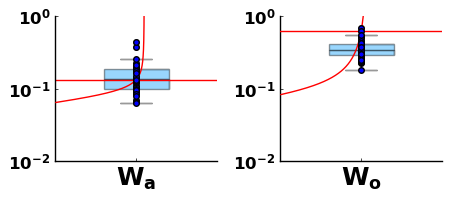

In [36]:
let
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo],
        layout = (1,2), distribution! = boxplot!)
    # plot!(p[1], ylim=(1e-4,1))
    # plot!(p[2], ylim=(1e-4,1))
end

In [37]:
name = "turnover_d0.98_mu0.015_lichee_W"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

## 2d poisson

In [32]:
N = 280

280

> samplingtumor

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Any[0.7565424803802372, 0.7207083906564353, 0.7105294251518515, 0.692458935587239]


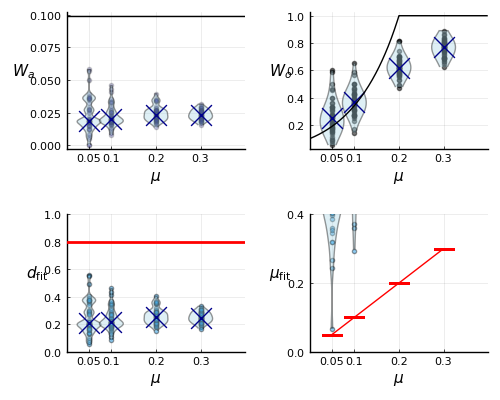

In [44]:
let data = tumorinfo_2d
    
    d = 0.8
    f_min = 1/500
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)
    
    plot(p1,p2, layout = (2,1), size=(500,400))
end

> clonetumor_coinc

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Any[0.4031507708134675, 0.361846672162064, 0.3903052920278271, 0.3639492478619223]


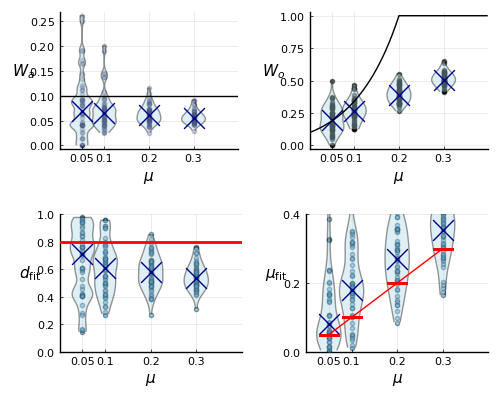

In [49]:
let data = tumorinfo_2d
    
    d = 0.8
    f_min = 1
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)
    
    plot(p1,p2, layout = (2,1), size=(500,400))
end

> clonetumor_lichee

## 3d poisson

In [13]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4770.558411021251

> samplingtumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.4840768986745022 | 0.6, mu 0.30000380930618487 | 0.3


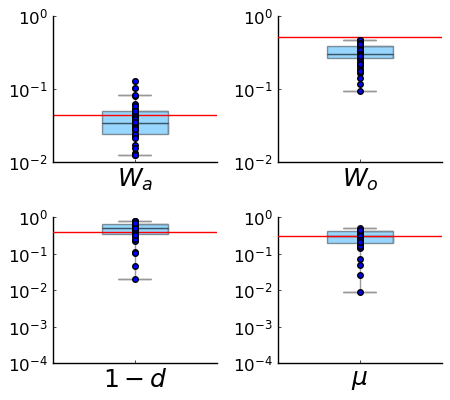

In [65]:
let
    d, mu = 0.6, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.5713047428280295 | 0.975, mu 0.25829635842198695 | 0.015


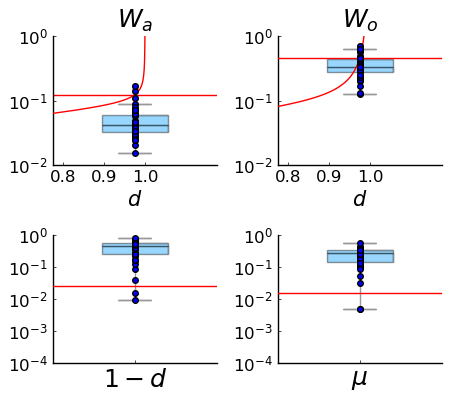

In [39]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

In [50]:
name = "turnover_d0.98_mu0.015_inference"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

> clonetumor_coinc

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.009379275706536181 | 0.015

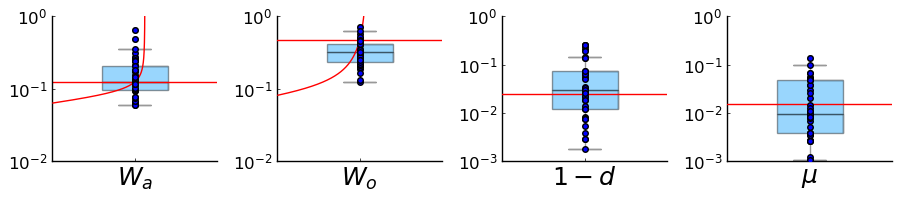

In [27]:
let 
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask]; plots = [:Wa, :Wo, :d, :mu], layout=(1,4),
        distribution! = boxplot!, dots! = scatter!, scale = 5)
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.009379275706536181 | 0.015


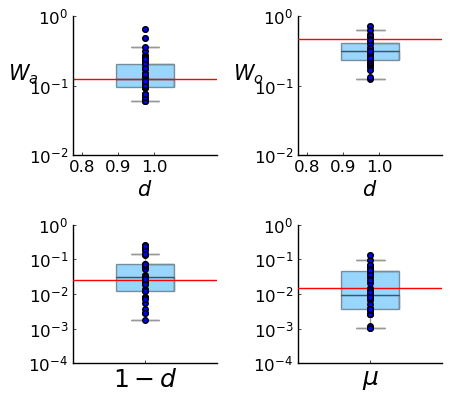

In [64]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6486435933525878 | 0.97, mu 0.3035332142993534 | 0.07


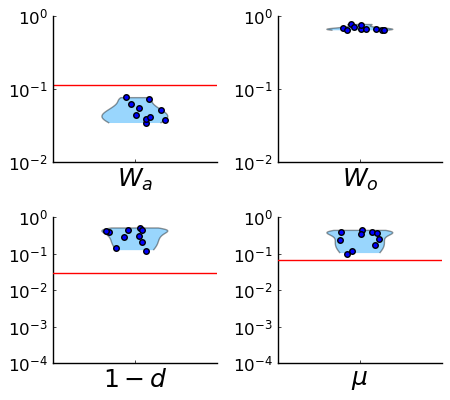

In [126]:
let
    d, mu = 0.97, 0.07
    tumorinfo = filter( r-> r.d == d && r.mu == mu, tumorinfo_3d)

    f_min = 2
    ds, mus, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.009379275706536181 | 0.015


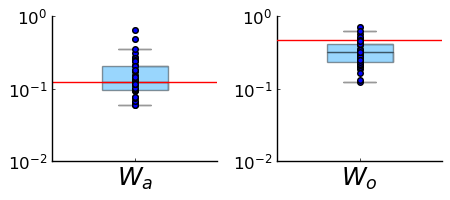

In [61]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo],
        layout = (1,2), distribution! = boxplot!)
    # plot!(size=(450,225))
    # plot!(p[3], ylim=(1e-4,1))
    # plot!(p[4], ylim=(1e-4,1))
end

In [65]:
name = "turnover_d0.975_mu0.015_coinc"
savefig(joinpath("Turnover\\turnover_plots\\experimental_data\\", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\experimental_data\\", name*".png"))

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9749747656877366 | 0.8, mu 0.017800385994454847 | 0.3


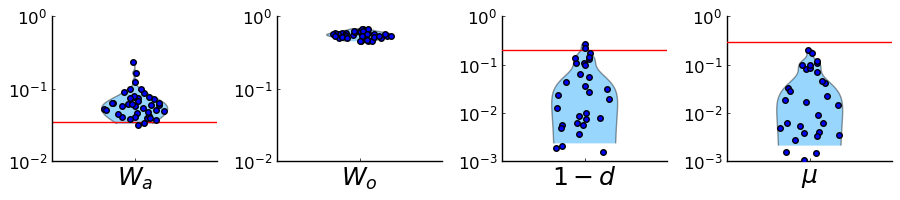

In [18]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.mu == mu, tumorinfo_3d)

    f_min = 1/100
    ds, mus, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds,  mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask]; plots = [:Wa, :Wo, :d, :mu], layout=(1,4),
        distribution! = boxplot!, dots! = scatter!, scale = 5)
    plot!(p[3], ylim=(1e-3,1))
end

> clonetumor_lichee

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.008857578596414116 | 0.015


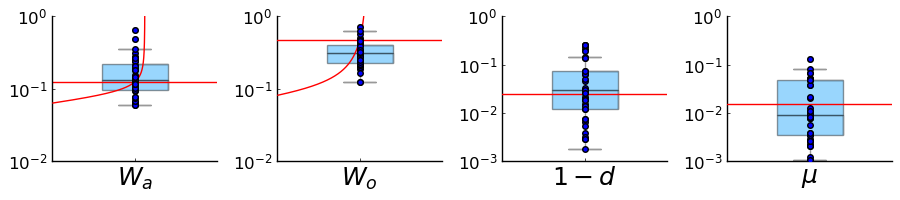

In [28]:
let 
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask]; plots = [:Wa, :Wo, :d, :mu], layout=(1,4),
        distribution! = boxplot!, dots! = scatter!, scale = 5)
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.008857578596414116 | 0.015


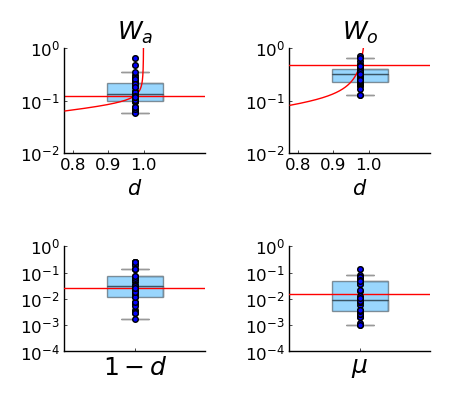

In [44]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[3], ylim=(1e-4,1))
    plot!(p[4], ylim=(1e-4,1))
end

In [41]:
name = "turnover_d0.975_mu0.015_lichee_poisson"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

### scale

#### *Li sampling*

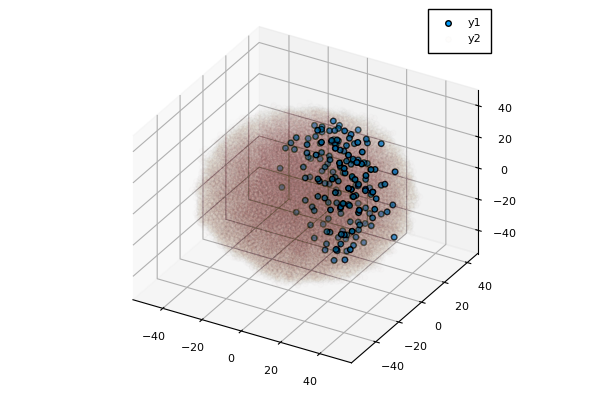

In [80]:
t=pi/3
m = [cos(t) -sin(t) 0; sin(t) cos(t) 0; 0 0 1.]

p = [ m*vec  for vec in tumorinfo_3d.samplingtumor[1].position]
scatter3d(getindex.(p,1),getindex.(p,2),getindex.(p,3))
p = [ m*vec  for vec in tumorinfo_3d.tumor[1].position]
scatter3d!(getindex.(p,1),getindex.(p,2),getindex.(p,3), alpha=0.01)

In [93]:
N = 2 * median( nrow.( tumorinfo_3d.samplingtumor ) )

336.0

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


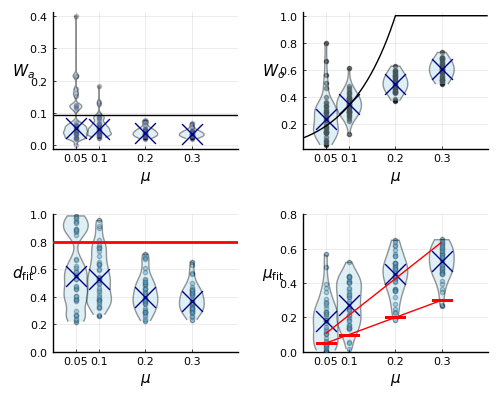

In [97]:
# let 
d = 0.8
f_min = 1
ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :clonetumor_coinc,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
    d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
    usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)

ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
    xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.8), scalex=15)

plot!(p2[2], 15*sort(unique(mus[mask])), 
    median(mufits[mask] ./ mus[mask])*sort(unique(mus[mask])),c=:red)

plot(p1,p2, layout = (2,1), size=(500,400))
# end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


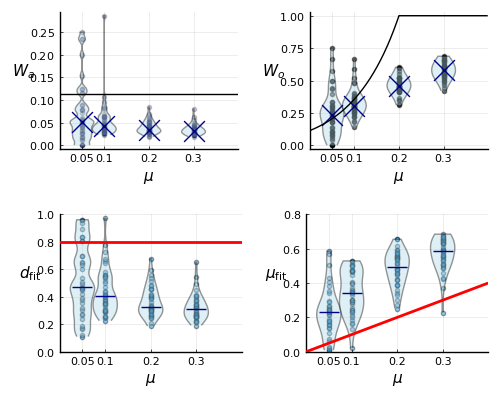

In [92]:
# let 
d = 0.8
f_min = 2

scalex=15

ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :clonetumor_coinc,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
    d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
    usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=scalex)

ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
    xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.8), scalex=scalex, markershape_median=:hline)

plot!(p2[2], scalex.*(0.:0.1:0.4), 
    0.:0.1:0.4,c=:red, lw=2)

plot(p1,p2, layout = (2,1), size=(500,400))
# end

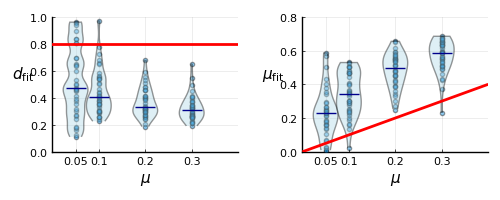

In [94]:
plot(p2)

In [95]:
savefig("Turnover\\turnover_plots\\inference\\turnover_Li_T1_3d_inference.pdf")

"C:\\Users\\ArmanAngaji\\OneDrive - Universität zu Köln\\Dokumente\\Uni-Köln\\Masterarbeit\\Workspace\\Julia_Master\\MasterProject_Julia\\Turnover\\turnover_plots\\inference\\turnover_Li_T1_3d_inference.pdf"

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


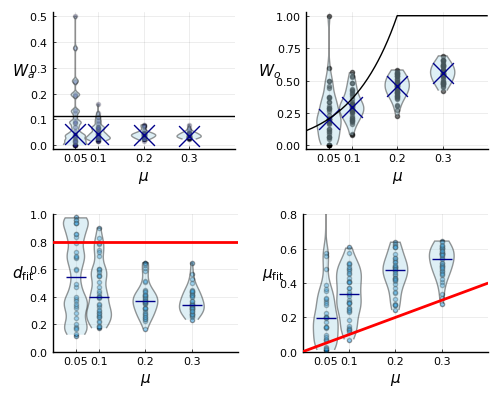

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [81]:
# let 
d = 0.8
f_min = 2

scalex=15

ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :clonetumor_coinc,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
    d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
    usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=scalex)

ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
    xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.8), scalex=scalex, markershape_median=:hline)

plot!(p2[2], scalex.*(0.:0.1:0.4), 
    0.:0.1:0.4,c=:red, lw=2)

plot(p1,p2, layout = (2,1), size=(500,400))
# end

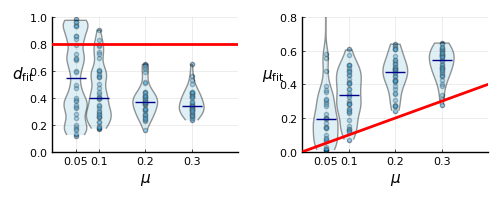

In [85]:
plot(p2)

In [86]:
savefig("Turnover\\turnover_plots\\inference\\turnover_Li_T2_3d_inference.pdf")

"C:\\Users\\ArmanAngaji\\OneDrive - Universität zu Köln\\Dokumente\\Uni-Köln\\Masterarbeit\\Workspace\\Julia_Master\\MasterProject_Julia\\Turnover\\turnover_plots\\inference\\turnover_Li_T2_3d_inference.pdf"

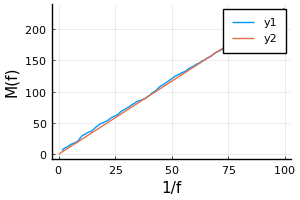

In [125]:
f = vcat( getproperty.(TumorGrowth.mutation_freqs.(tumorinfo.tumor),:frequency)...)
M(f,scale=1/nrow(tumorinfo),res=1/100,size=(300,200))
plot!(0:100,x->x*0.07/(1-0.97))

In [193]:
N = 2 * median( nrow.( tumorinfo_3d.samplingtumor ) )

336.0

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


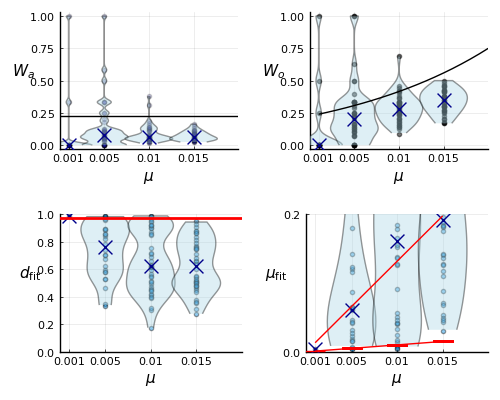

In [194]:
let 
    scalex, ms_median = 150, 10
    
    d = 0.975
    f_min = 1
    ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.02], xticks= unique(mus), scalex=scalex, ms_median=ms_median)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.02], xticks= unique(mus), ylim_mu=(0.,0.2), scalex=scalex, ms_median=ms_median)

    plot!(p2[2], scalex*sort(unique(mus[mask])), 
        median(mufits[mask] ./ mus[mask])*sort(unique(mus[mask])),c=:red)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


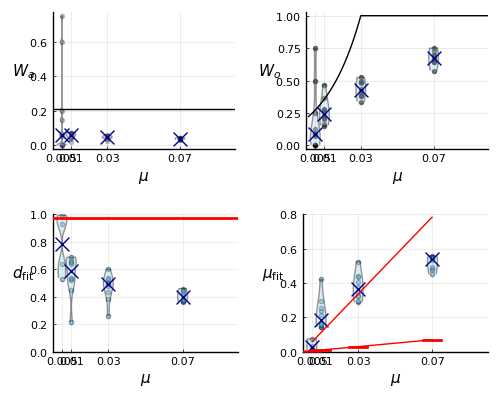

In [188]:
let 
    scalex, ms_median = 150, 10
    
    d = 0.97
    f_min = 1
    ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.1], xticks= unique(mus), scalex=scalex, ms_median=ms_median)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.1], xticks= unique(mus), ylim_mu=(0.,0.8), scalex=scalex, ms_median=ms_median)

    plot!(p2[2], scalex*sort(unique(mus[mask])), 
        median(mufits[mask] ./ mus[mask])*sort(unique(mus[mask])),c=:red)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

#### *Ling sampling*

In [154]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4770.558411021251

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


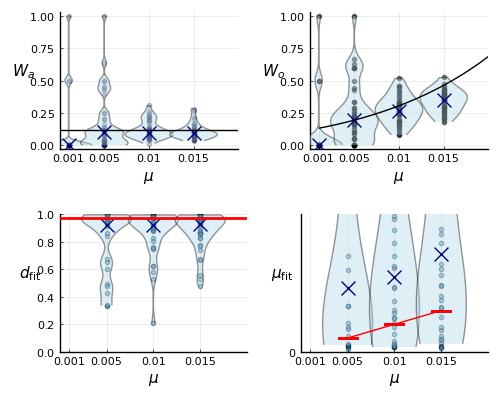

In [160]:
let 
    d = 0.975
    f_min = 2
    ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.02], xticks= unique(mus), scalex=150, ms_median=10)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.02], xticks= unique(mus), ylim_mu=(0.,0.05), scalex=150, ms_median=10)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


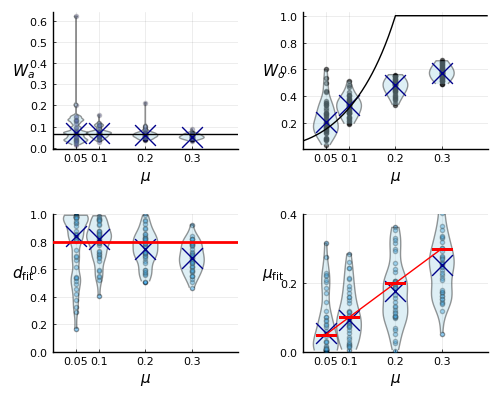

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [19]:
let 
    d = 0.8
    f_min = 2
    ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


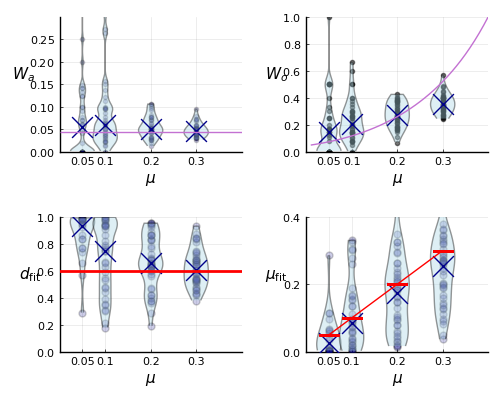

In [112]:
let 
    d = 0.6
    f_min = 2
    ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N/f_min, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= (15 *unique(mus), unique(mus)), scalex=15)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= (15*unique(mus), unique(mus)), ylim_mu=(0.,0.4), scalex=15)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6927023748993887 | 0.8, mu 0.2332227769912786 | 0.3


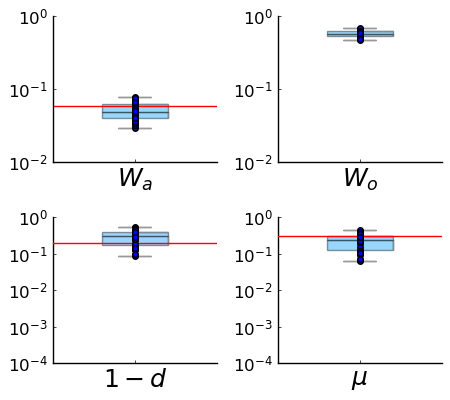

In [149]:
let
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.7474190656990087 | 0.8, mu 0.16634699952137344 | 0.15


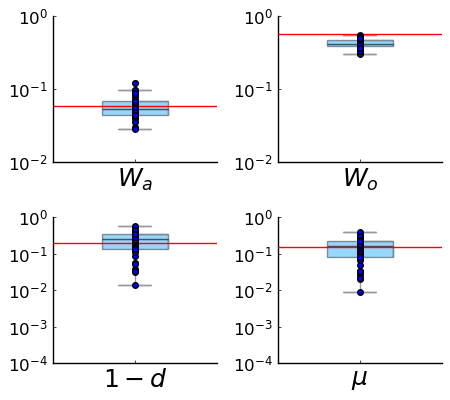

In [144]:
let
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/2 , )
    p = plot_func( N/ f_min, d, mu/2, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.7996329994478116 | 0.8, mu 0.10276526622458815 | 0.09999999999999999


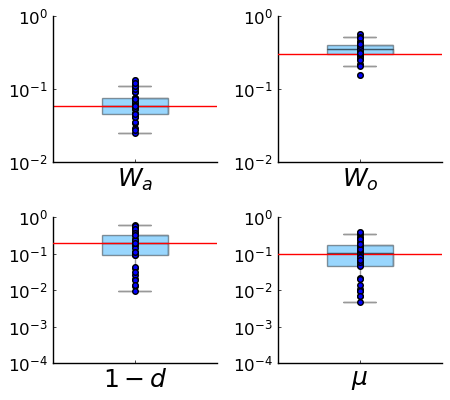

In [152]:
let
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/3 , )
    p = plot_func( N/ f_min, d, mu/3, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.8807861799621199 | 0.8, mu 0.05997827696386482 | 0.075


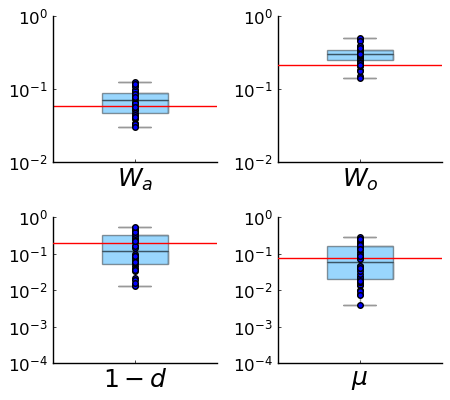

In [160]:
let
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/4 , )
    p = plot_func( N/ f_min, d, mu/4, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

#### 3d single cells

In [32]:
N = 500

500

In [86]:
mus = unique(tumorinfo_3d.μ)

4-element Vector{Union{Missing, Float64}}:
 0.3
 0.2
 0.1
 0.05

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


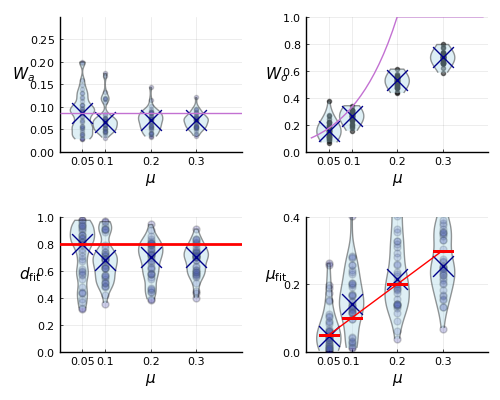

In [88]:
let 
    d = 0.8
    f_min = 1/500
    ds, mus, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= (15 *unique(mus), unique(mus)), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= (15*unique(mus), unique(mus)), ylim_mu=(0.,0.4), scalex=15)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6777749904587803 | 0.8, mu 0.27502932633749755 | 0.3


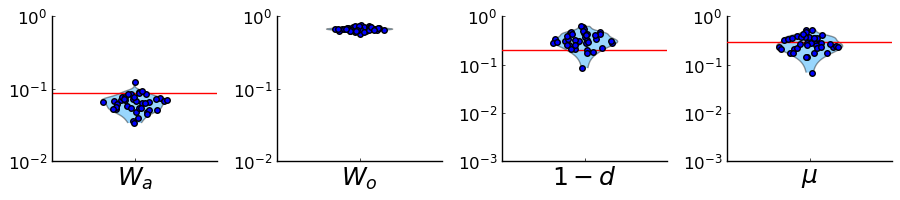

In [43]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.7133867925714646 | 0.8, mu 0.23668409696177184 | 0.3


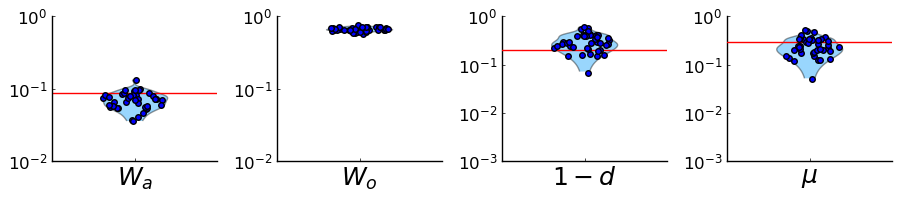

In [14]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6429911340434096 | 0.8, mu 0.20393423088712878 | 0.15


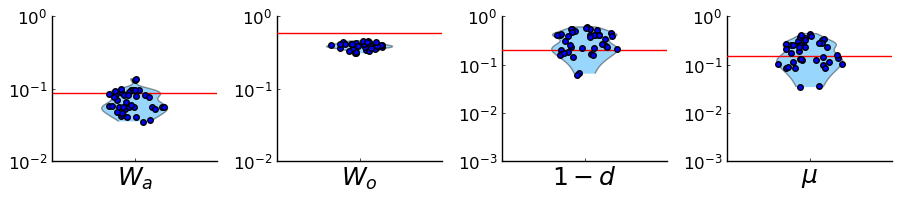

In [39]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/2 , )
    p = plot_func(N, d, mu/2, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6493442183870092 | 0.8, mu 0.14862660417274065 | 0.09999999999999999


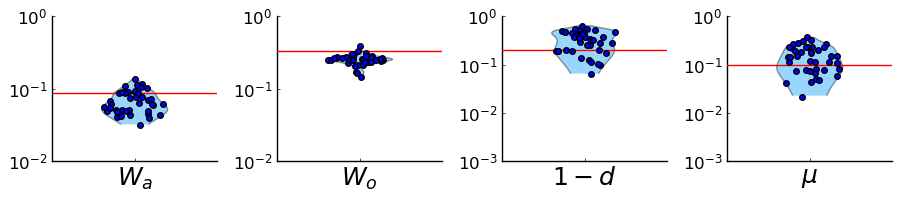

In [47]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/3 , )
    p = plot_func(N, d, mu/3, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.688753842830227 | 0.8, mu 0.09830730013950484 | 0.075


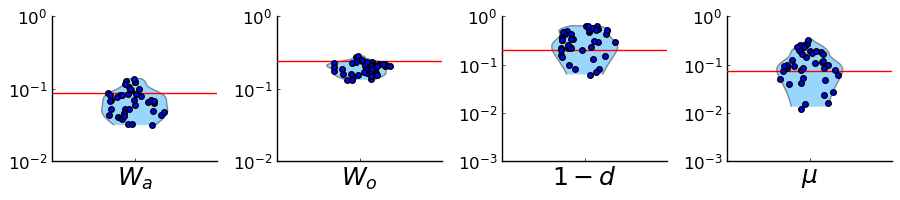

In [50]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/4 , )
    p = plot_func(N, d, mu/4, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.819101929294713 | 0.8, mu 0.027695656033210544 | 0.03


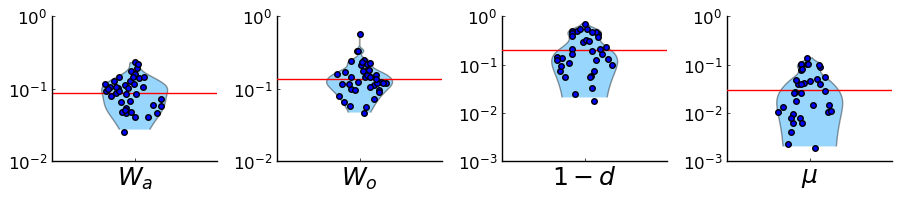

In [60]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/10 , )
    p = plot_func(N, d, mu/10, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6776793728494425 | 0.8, mu 0.02172110774245847 | 0.02


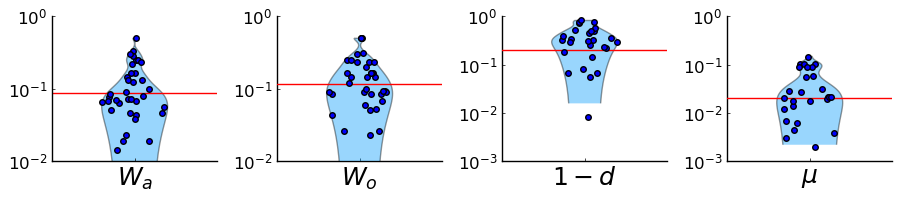

In [63]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/15 , )
    p = plot_func(N, d, mu/15, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.8546982008934968 | 0.8, mu 0.014032913952264029 | 0.015


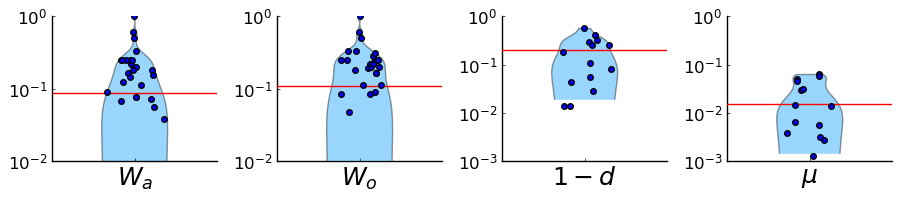

In [70]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/20 , )
    p = plot_func(N, d, mu/20, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

In [91]:
let 
    d, mu = 0.8, 0.3
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 1/500
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu/30 , )
    # p = plot_func(N, d, mu/30, ds,Wa,Wo,dfits[mask],mufits[mask])
    # plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.8557896982496819 | 0.8, mu 0.011781041774019486 | 0.01


## Selection

### nonspatial

In [241]:
N = 500

500

In [235]:
mus = unique(tumorinfo_selection.mu)

4-element Vector{Float64}:
 0.3
 0.2
 0.1
 0.05

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Any[0.2681750488011884, 0.21663388623265437, 0.2960740947589409, 0.21751054832662428]


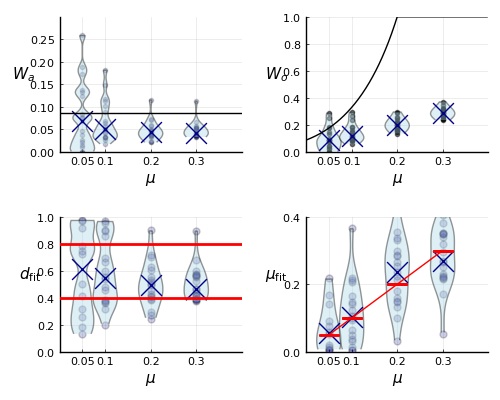

In [157]:
let data = filter(r->r.N1==100,tumorinfo)
    data.d = data.d1
    
    d = 0.8
    f_min = 1/500
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= (15 *unique(mus), unique(mus)), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= (15*unique(mus), unique(mus)), ylim_mu=(0.,0.4), scalex=15)
    
    hline!(p2[1], [first(data.d2)], c=:red,lw=2)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

d1/d2 0.125±0.076


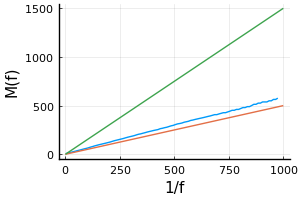

In [153]:
mu = 0.3
let data = filter( r-> r.N1 == 100 && r.mu == mu, tumorinfo)
    
    ratios = map( eachrow(data) ) do row
        d1,d2 = row.d1, row.d2
        count(row.tumor.d .== d1) / count(row.tumor.d .== d2)
    end 
    println("d1/d2 ",round(mean(ratios),digits=3), "±", round(std(ratios),digits=3))
    
    f = getproperty.(TumorGrowth.mutation_freqs.( data.tumor ), :frequency)
    
    res = 1000
    M(vcat(f...), size=(300,200), legend=:none, res=1/res, scale=1/nrow(data))
    plot!(0:res, x-> x*mu/(1-0.4))
    plot!(0:res, x-> x*mu/(1-0.8))

end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


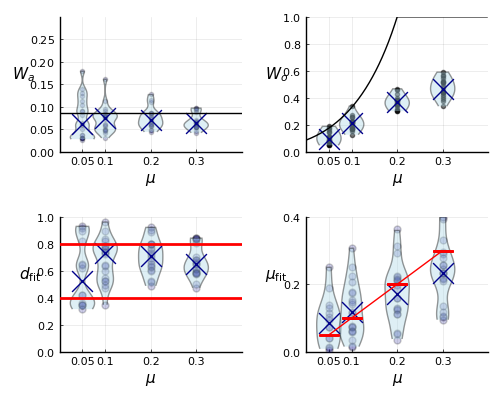

In [158]:
let data = filter(r->r.N1==1000,tumorinfo)
    data.d = data.d1
    
    d = 0.8
    f_min = 1/500
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= (15 *unique(mus), unique(mus)), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)

    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= (15*unique(mus), unique(mus)), ylim_mu=(0.,0.4), scalex=15)

    hline!(p2[1], [first(data.d2)], c=:red,lw=2)
    
    plot(p1,p2, layout = (2,1), size=(500,400))
end

d1/d2 1.92±1.454


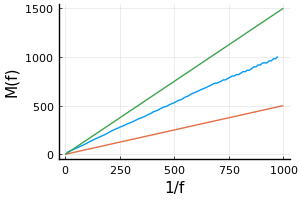

In [150]:
mu = 0.3
let data = filter( r-> r.N1 == 1000 && r.mu == mu, tumorinfo)
    
    ratios = map( eachrow(data) ) do row
        d1,d2 = row.d1, row.d2
        count(row.tumor.d .== d1) / count(row.tumor.d .== d2)
    end 
    println("d1/d2 ",round(mean(ratios),digits=3), "±", round(std(ratios),digits=3))
    
    f = getproperty.(TumorGrowth.mutation_freqs.( data.tumor ), :frequency)
    
    res = 1000
    M(vcat(f...), size=(300,200), legend=:none, res=1/res, scale=1/nrow(data))
    plot!(0:res, x-> x*mu/(1-0.4))
    plot!(0:res, x-> x*mu/(1-0.8))

end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


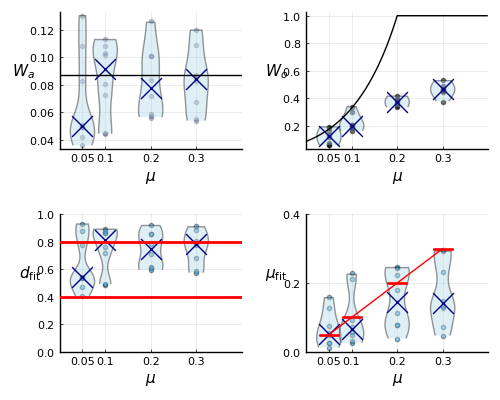

In [242]:
let data = filter(r->r.N1==1000,tumorinfo)
    data.d = data.d1
    
    d = 0.8
    f_min = 1/500
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)

    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)

    hline!(p2[1], [first(data.d2)], c=:red,lw=2)
    
    plot(p1,p2, layout = (2,1), size=(500,400))
end

d1/d2 1.766±0.747


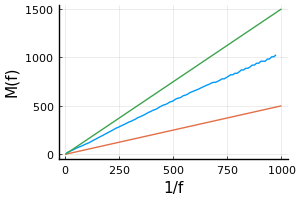

In [240]:
mu = 0.3
let data = filter( r-> r.N1 == 1000 && r.mu == mu, tumorinfo)
    
    ratios = map( eachrow(data) ) do row
        d1,d2 = row.d1, row.d2
        count(row.tumor.d .== d1) / count(row.tumor.d .== d2)
    end 
    println("d1/d2 ",round(mean(ratios),digits=3), "±", round(std(ratios),digits=3))
    
    f = getproperty.(TumorGrowth.mutation_freqs.( data.tumor ), :frequency)
    
    res = 1000
    M(vcat(f...), size=(300,200), legend=:none, res=1/res, scale=1/nrow(data))
    plot!(0:res, x-> x*mu/(1-0.4))
    plot!(0:res, x-> x*mu/(1-0.8))

end

### 2d

In [15]:
N = 280

280

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Any[0.5564277641873787, 0.5670203083747491, 0.1623692945691921, 0.4276678214727095]


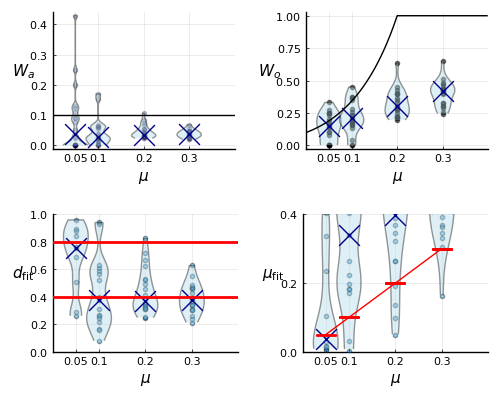

In [45]:
let data = filter(r->r.N1==100,tumorinfo_selection)
    data.d = data.d1
    
    d = 0.8
    f_min = 2
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)
    
    hline!(p2[1], [first(data.d2)], c=:red,lw=2)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Any[0.4963111549044083, 0.4316566956439585, 0.4927595460602025, 0.4346407835728843]


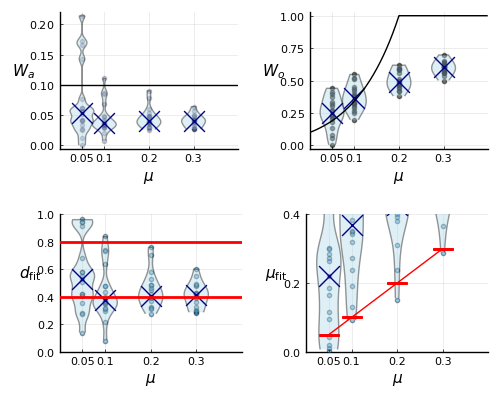

In [44]:
let data = filter(r->r.N1==1000,tumorinfo_selection)
    data.d = data.d1
    
    d = 0.8
    f_min = 1
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)
    
    hline!(p2[1], [first(data.d2)], c=:red,lw=2)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

###  3d

In [217]:
n = median( nrow.( tumorinfo_selection.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4770.558411021251

d1/d2 1.766±0.747


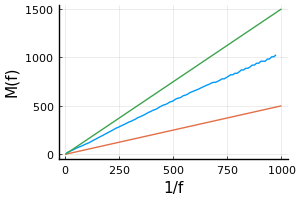

In [221]:
mu = 0.3
let data = filter( r-> r.N1 == 1000 && r.mu == mu, tumorinfo)
    
    ratios = map( eachrow(data) ) do row
        d1,d2 = row.d1, row.d2
        count(row.tumor.d .== d1) / count(row.tumor.d .== d2)
    end 
    println("d1/d2 ",round(mean(ratios),digits=3), "±", round(std(ratios),digits=3))
    
    f = getproperty.(TumorGrowth.mutation_freqs.( data.tumor ), :frequency)
    
    res = 1000
    M(vcat(f...), size=(300,200), legend=:none, res=1/res, scale=1/nrow(data))
    plot!(0:res, x-> x*mu/(1-0.4))
    plot!(0:res, x-> x*mu/(1-0.8))

end

> Ling sampling

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Any[0.08248216340996097, 0.1388456244728218, 0.06733577081295868, 0.21624049437536833]


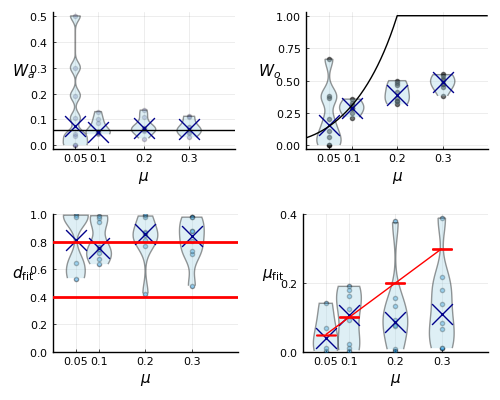

In [220]:
let data = filter(r->r.N1==1000,tumorinfo_selection)
    data.d = data.d1
    
    d = 0.8
    f_min = 1
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)
    
    hline!(p2[1], [first(data.d2)], c=:red,lw=2)

    plot(p1,p2, layout = (2,1), size=(500,400))
end

> Li sampling

In [230]:
N = 2 * median( nrow.( tumorinfo_selection.samplingtumor ) )

336.0

get_turnover now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


infer_params now also returns mus!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Any[0.37825697879803083, 0.357088320427429, 0.4342986299355564, 0.5842948293593345]


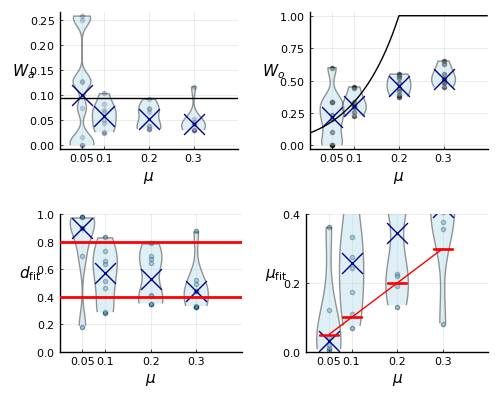

In [231]:
let data = filter(r->r.N1==1000,tumorinfo_selection)
    data.d = data.d1
    
    d = 0.8
    f_min = 1
    ds, mus, Wa, Wo = get_turnover(data; useknown_N = false, f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin_vary_mu(mus[mask], Wa[mask], Wo[mask]; 
        d = d, N=N, yguidefontrotation=-90, size=(500,200),
        usecorrection=true, xlim=[0., 0.4], xticks= unique(mus), scalex=15)
    # plot!(p1[1],  yticks=0:0.1:0.3,)

    ds, mus, dfits, mufits = infer_params( data; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N)
    println(first(mufits,4))
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin_vary_mu(mus[mask], dfits[mask], mufits[mask]; d=d, size=(500,200), 
        xlim=[0., 0.4], xticks= unique(mus), ylim_mu=(0.,0.4), scalex=15)
    
    hline!(p2[1], [first(data.d2)], c=:red,lw=2)

    plot(p1,p2, layout = (2,1), size=(500,400))
end